In [1]:
import numpy as np
import find_filter_coefficients as find_fc
import find_wavelet_coefficients as fwc
import fitness_function as ff
import matplotlib.pyplot as plt
import load_data as ld
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from find_best_wavelet import pso_search_process


## Import Data

Number of samples for each label: label
N    29649
/     6975
V     4424
R     3969
L     1990
A      636
Name: count, dtype: int64 

Number of data 47643


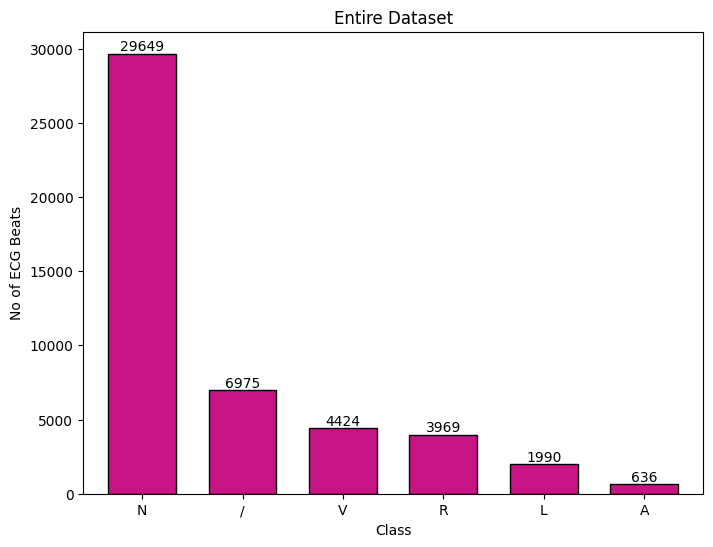

In [2]:
# Required records and classes from MIT-BIH dataset for the study

req_records = [100, 102, 104, 105, 106, 107, 118, 119, 200, 201, 202, 203, 205, 
                    208, 209, 212, 213, 214, 215,217]

req_classes = ["N", "L", "R", "A", "V", "/"]

data = ld.load_mit_datset(req_records, req_classes) # Load the dataset

# Calculate the count of each label
label_counts = data["label"].value_counts()

print("Number of samples for each label:",label_counts,"\n")
print("Number of data",data.shape[0])

plt.figure(figsize=(8, 6))

ax = label_counts.plot(kind='bar', color='mediumvioletred', edgecolor='black', width=0.675)

plt.title("Entire Dataset")
plt.xlabel("Class")
plt.ylabel("No of ECG Beats")
plt.xticks(rotation=0)

for i, count in enumerate(label_counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.show()

## Prepare Training Data and Testing Data

In [3]:
y = data.iloc[:, -1]   # Labels (the last column)

# Define the desired number of beats for each ECG class
sample_sizes = {'N': 37, 'A': 24, 'V':25, 'R': 13, 'L': 13, '/': 13}

train_df = data.groupby(y.name).apply(
    lambda x: x.sample(n=min(len(x), sample_sizes.get(x.name, 0)), replace=False)
).reset_index(drop=True)

print("Number of samples for each label:",train_df["label"].value_counts(),"\n")
print("Number of data",train_df.shape[0])

# Separate the training features and labels
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

# Get the test set by dropping the training samples from the original dataset
test_df = data.drop(train_df.index)

# Separate the test features and labels
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]


print("Training set size:", train_df.shape)
print("Test set size:", test_df.shape)

Number of samples for each label: label
N    37
V    25
A    24
/    13
L    13
R    13
Name: count, dtype: int64 

Number of data 125
Training set size: (125, 304)
Test set size: (47518, 304)


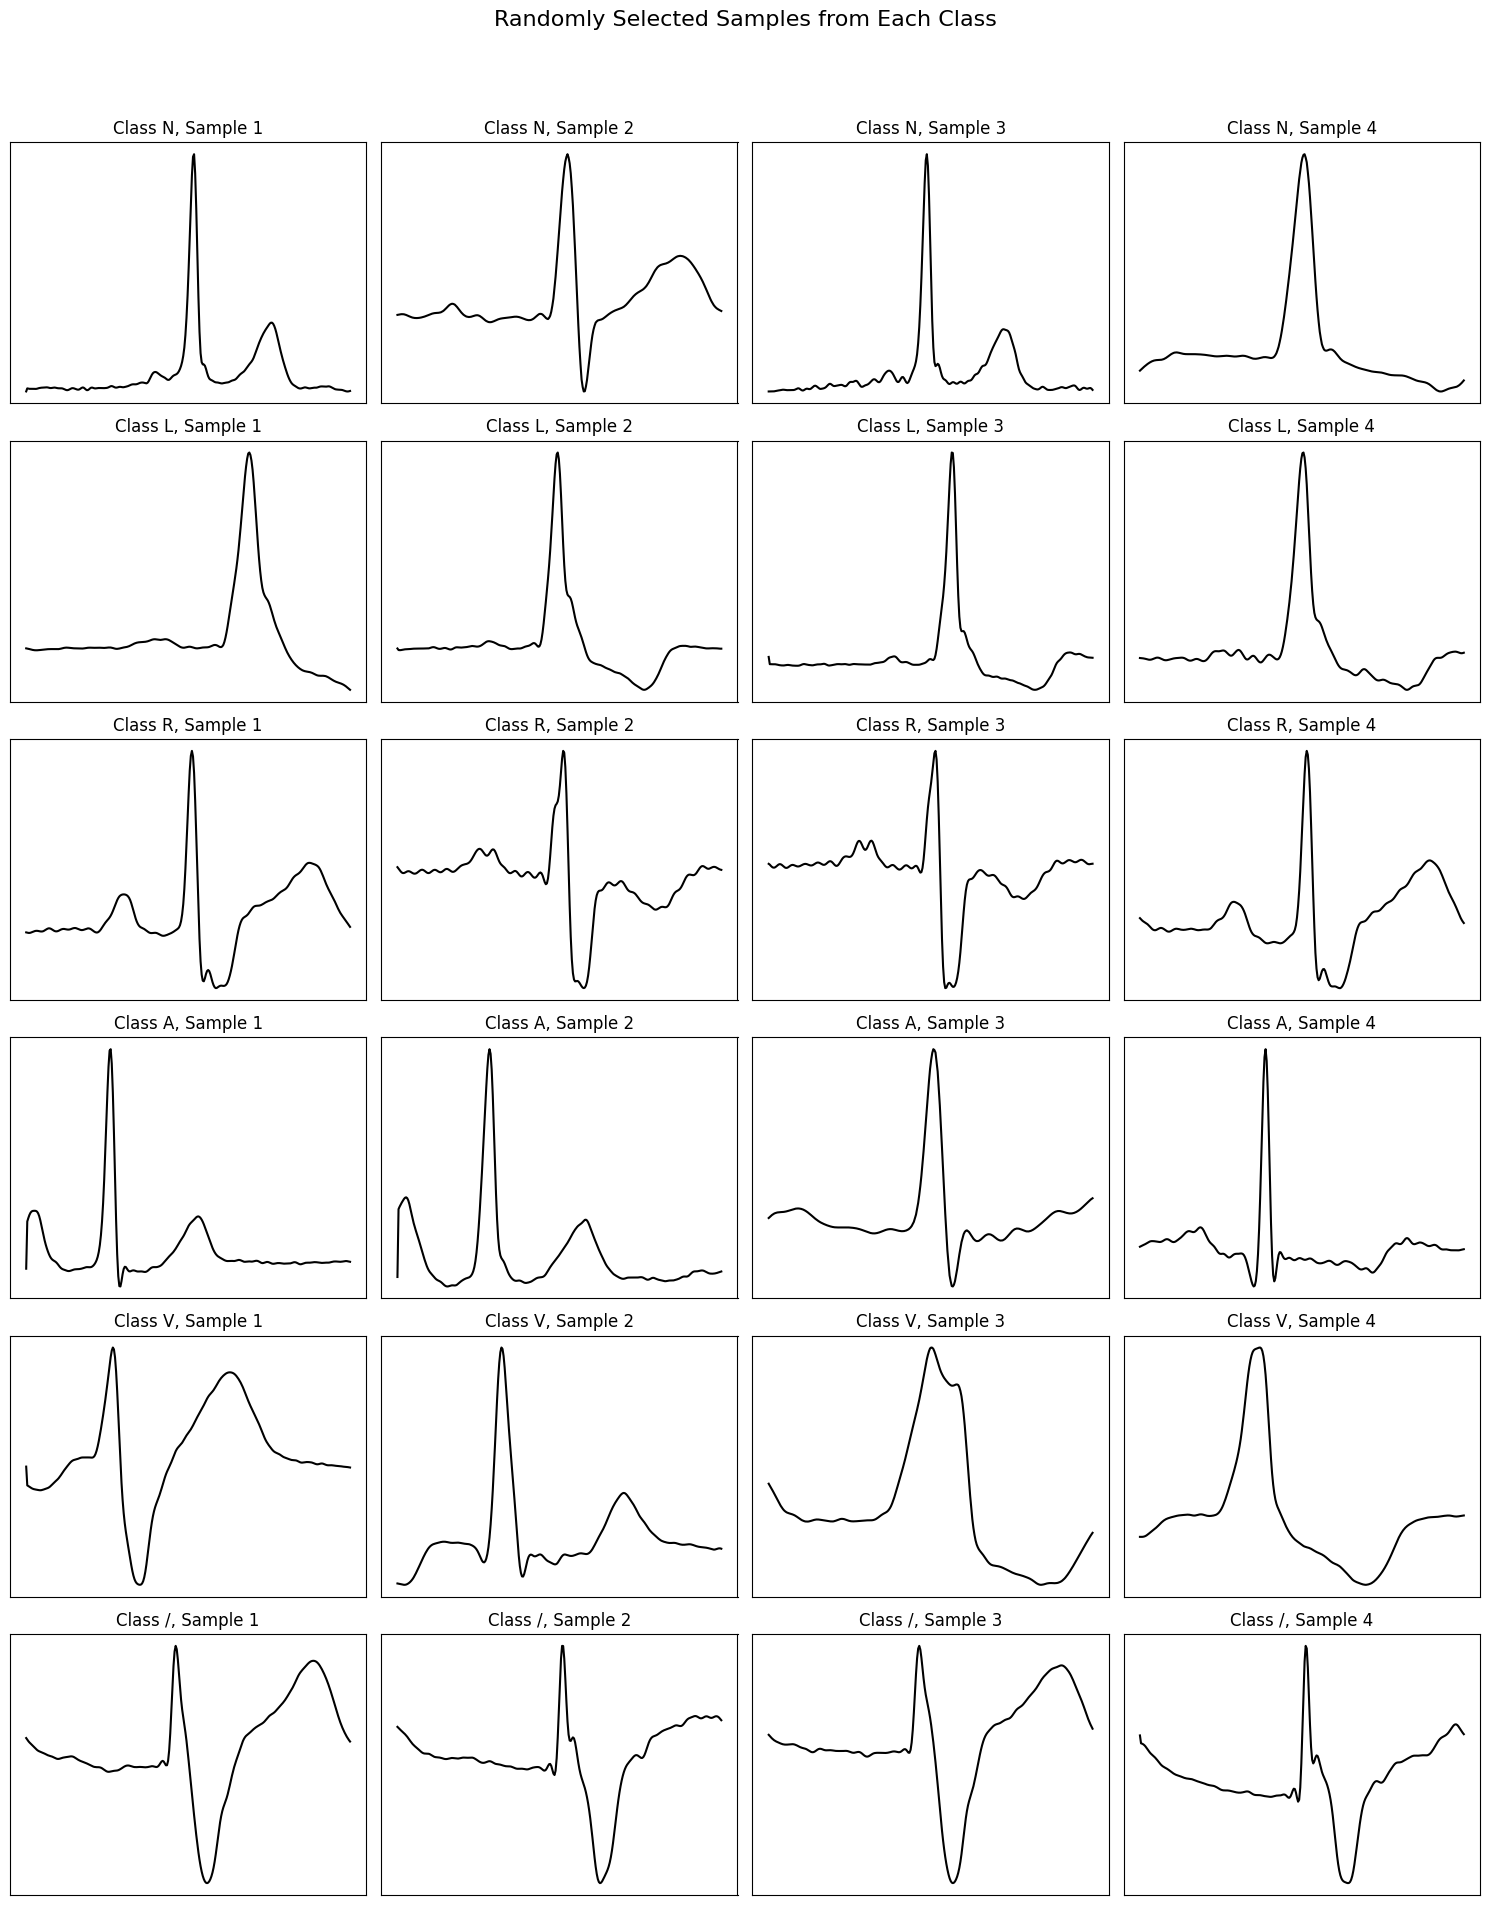

In [4]:
# Define the plot
fig, axes = plt.subplots(6, 4, figsize=(15, 20))
fig.suptitle('Randomly Selected Samples from Each Class', fontsize=16)

# Loop through each class
for j, class_label in enumerate(["N", "L", "R", "A", "V", "/"]):
    # Filter samples for the current class
    class_samples = X_train[y_train == class_label].iloc[:, 3:303]
    # Randomly select 4 samples
    random_samples = class_samples.sample(4, random_state=0)
    # Plot each sample in its respective subplot
    for i in range(4):
        ax = axes[j, i]
        ax.plot(random_samples.iloc[i], color='black')
        ax.set_title(f"Class {class_label}, Sample {i+1}")
        ax.set_xticks([])  # Remove x-axis ticks for clarity
        ax.set_yticks([])  # Remove y-axis ticks for clarity

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Particle Swarm Optimization (PSO) to find the best wavelet

In [5]:
# Define wavelet parameters
N = 20   # Filter length 
L = 3    # Number of levels in the wavelet decomposition

# Define the PSO parameters
S = 20        # Number of particles in the swarm(Swarm size)
d = int(N/2)  # Dimension of the search space
c1=1  # Regulate the relative velcity with respect to the personal best          
c2=1  # Regulate the relative velcity with respect to the global best
w=0.75 # Inertia weight
iterations= 50 # Number of iterations
eps = 1e-20 # Tolerance for the stopping criterion

# Find the best wavelet coefficients
global_best_position, training_accuracies = pso_search_process(X_train, y_train, S, iterations, w, c1, c2, d, eps, L, 'd')

iteration 0 completed
iteration 1 completed
iteration 2 completed
iteration 3 completed
iteration 4 completed
iteration 5 completed
iteration 6 completed
iteration 7 completed
iteration 8 completed
iteration 9 completed
iteration 10 completed
iteration 11 completed
iteration 12 completed
iteration 13 completed
iteration 14 completed
iteration 15 completed
iteration 16 completed
iteration 17 completed
iteration 18 completed
iteration 19 completed
iteration 20 completed
iteration 21 completed
iteration 22 completed
iteration 23 completed
iteration 24 completed
iteration 25 completed
iteration 26 completed
iteration 27 completed
iteration 28 completed
iteration 29 completed
iteration 30 completed
iteration 31 completed
iteration 32 completed
iteration 33 completed
iteration 34 completed
iteration 35 completed
iteration 36 completed
iteration 37 completed
iteration 38 completed
iteration 39 completed
iteration 40 completed
iteration 41 completed
iteration 42 completed
iteration 43 complete

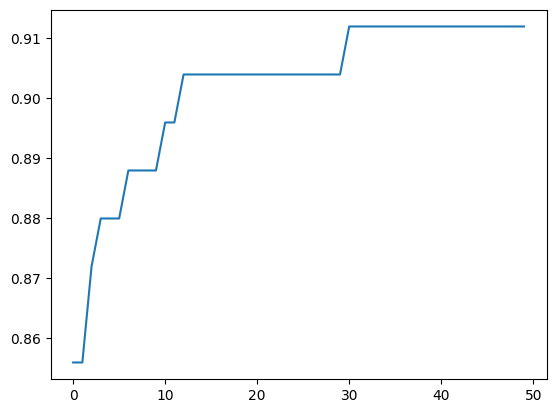

In [6]:
plt.plot(training_accuracies)

In [7]:
print("global best position is \n ", global_best_position) 

global best position is 
  [8.41446047 6.67578305 5.29068127 1.2561178  6.38253157 6.22768354
 4.15152118 2.88347681 4.61654728 2.11779291]


In [8]:
v_l = find_fc.lowpass_filter(global_best_position)
v_h = find_fc.high_pass_filter(v_l)

In [9]:
# Calculate the energy of the low pass and high pass filters 
print("Low pass filter ennergy:", np.sum(v_l**2))
print("High pass filter ennergy:", np.sum(v_h**2))
# check the orthogonality of the filters
print("Orthogonality of the filters:", np.sum(v_l*v_h))


Low pass filter ennergy: 1.0000000000000002
High pass filter ennergy: 1.0
Orthogonality of the filters: 1.7436173219229772e-17


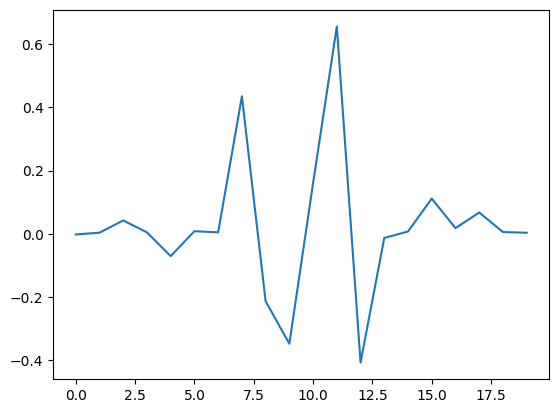

In [10]:
plt.plot(v_l)

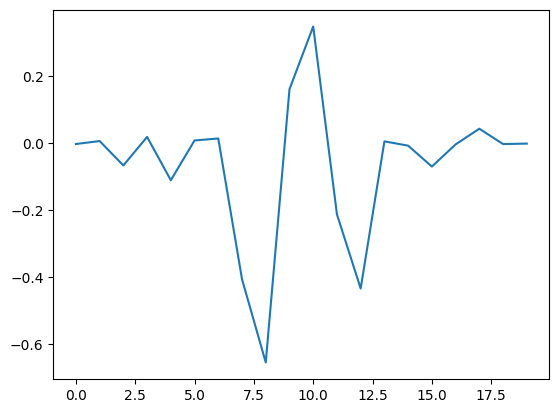

In [11]:
plt.plot(v_h)

## Train SVM for testing phase

In [12]:
def train_svm( X_train, y_train, positions, level, coeff_type):
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    
    if coeff_type == 'a':
        var = 0
    elif coeff_type == 'd':
        var = 1
    
    lowpass_filter = find_fc.lowpass_filter(positions)
    highpass_filter = find_fc.high_pass_filter(lowpass_filter)
    
    X_train_  = []
    for i in  range(len(X_train)):
        
        ecg_morph = X_train[i,3:]
        ecg_temporal = X_train[i,1:3]
        wavelet_coefficients, _ = fwc.wavelet_coefficients(ecg_morph, lowpass_filter, highpass_filter, level)
        pp_wavelet_coefficients = wavelet_coefficients[var]
        X_train_.append(np.concatenate((pp_wavelet_coefficients,ecg_temporal)))
    
    X_train_ = np.array(X_train_)
    
    # Train SVM
    model_t = SVC(kernel='rbf', C=100, gamma='scale')

    model_t.fit(X_train_, y_train)
    
    return  model_t

def test_accuracy(X_test, y_test, model, positions, level, coeff_type):
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    if coeff_type == 'a':
        var = 0
    elif coeff_type == 'd':
        var = 1
        
    lowpass_filter = find_fc.lowpass_filter(positions)
    highpass_filter = find_fc.high_pass_filter(lowpass_filter)
    
    X_test_  = []
    for i in  range(len(X_test)):
        
        ecg_morph = X_test[i,3:]
        ecg_temporal = X_test[i,1:3]
        wavelet_coefficients, _ = fwc.wavelet_coefficients(ecg_morph, lowpass_filter, highpass_filter, level)
        pp_wavelet_coefficients = wavelet_coefficients[var]
        X_test_.append(np.concatenate((pp_wavelet_coefficients,ecg_temporal)))
        
    X_test_ = np.array(X_test_)

    y_pred = model.predict(X_test_)

    correct = np.sum(y_test == y_pred)
    accuracy = correct / len(y_test)
    
    # Print accuracy
    print("Accuracy:", accuracy)
    
    # Calculate and print/plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    plt.figure(figsize=(8, 6))
    import seaborn as sns
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy

In [13]:
X_train, X_test, y_train, y_test = train_test_split(test_df.iloc[:,:-1], test_df['label'], test_size=0.9, random_state=42)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
model = train_svm(X_train, y_train, global_best_position, L , 'd')
print(model)

Training set size: 4751
Testing set size: 42767
(4751, 303)
SVC(C=100)


Accuracy: 0.9822059064231767
Confusion Matrix:
 [[ 6215     0     0    20     1     4]
 [    0   437     0   134     0     7]
 [    2     0  1798    19     0     0]
 [   73    48    27 26233    34   155]
 [    0     1     0    34  3554     2]
 [   10    34    13   136     7  3769]]


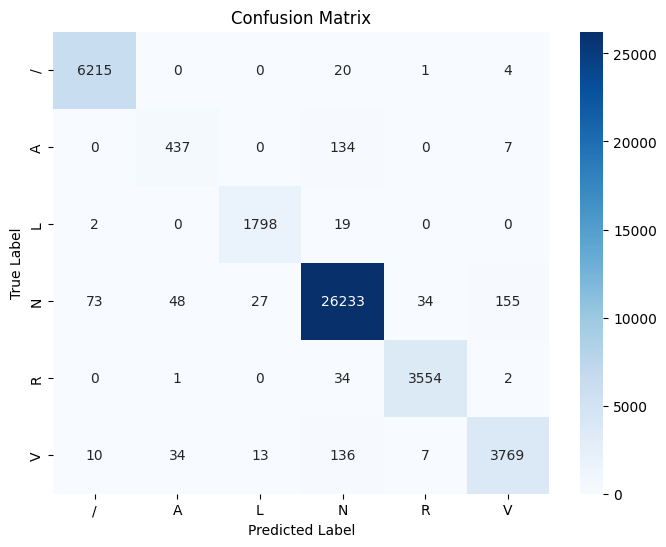

In [14]:
test_accuracy_ = test_accuracy(X_test, y_test, model, global_best_position, L, 'd')

## Compare with db10 wavelet

In [15]:
import pywt
def train_svm( X_train, y_train, positions, level, coeff_type):
   
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    
    if coeff_type == 'a':
        var = 0
    elif coeff_type == 'd':
        var = 1
    
    X_train_  = []
    for i in  range(len(X_train)):
        
        ecg_morph = X_train[i,3:]
        ecg_temporal = X_train[i,1:3]
        wavelet_coefficients = pywt.wavedec(ecg_morph, 'db10', level=level, mode='symmetric')
        pp_wavelet_coefficients = wavelet_coefficients[var]
        X_train_.append(np.concatenate((pp_wavelet_coefficients,ecg_temporal)))
    
    X_train_ = np.array(X_train_)
    
    # Train SVM
    model_t = SVC(kernel='rbf', C=100, gamma='scale')

    model_t.fit(X_train_, y_train)
    
    return  model_t

def test_accuracy(X_test, y_test, model, positions, level, coeff_type):
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    if coeff_type == 'a':
        var = 0
    elif coeff_type == 'd':
        var = 1
        
    lowpass_filter = find_fc.lowpass_filter(positions)
    highpass_filter = find_fc.high_pass_filter(lowpass_filter)
    
    X_test_  = []
    for i in  range(len(X_test)):
        
        ecg_morph = X_test[i,3:]
        ecg_temporal = X_test[i,1:3]
        wavelet_coefficients = pywt.wavedec(ecg_morph, 'db10', level=level, mode='symmetric')
        pp_wavelet_coefficients = wavelet_coefficients[var]
        X_test_.append(np.concatenate((pp_wavelet_coefficients,ecg_temporal)))
        
    X_test_ = np.array(X_test_)

    y_pred = model.predict(X_test_)

    correct = np.sum(y_test == y_pred)
    accuracy = correct / len(y_test)
    
    # Print accuracy
    print("Accuracy:", accuracy)
    
    # Calculate and print/plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    plt.figure(figsize=(8, 6))
    import seaborn as sns
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy

In [16]:
X_train, X_test, y_train, y_test = train_test_split(test_df.iloc[:,:-1], test_df['label'], test_size=0.8, random_state=42)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
model = train_svm(X_train, y_train, global_best_position, L , 'd')
print(model)

Training set size: 9503
Testing set size: 38015
(9503, 303)
SVC(C=100)


Accuracy: 0.8914375904248323
Confusion Matrix:
 [[ 5395     1    16    72    34     5]
 [    2   300     0    66     9   131]
 [   20     0   962   631    10     0]
 [   70    53   233 22106   343   828]
 [   81     5    16   611  2471     5]
 [   15    77     6   766    21  2654]]


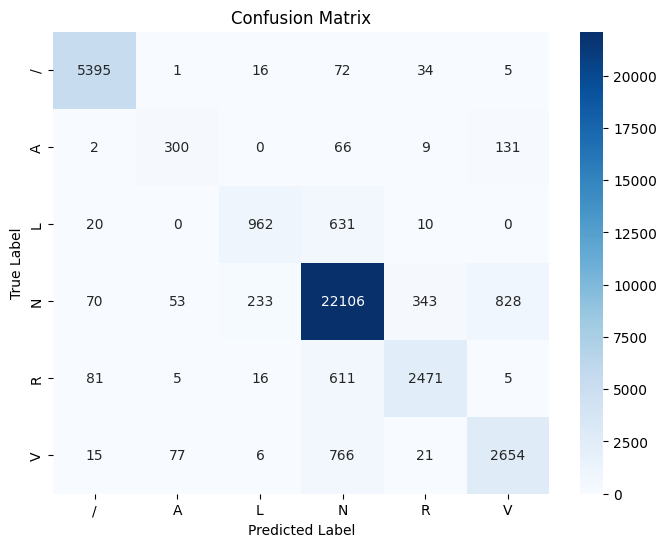

In [17]:
test_accuracy_ = test_accuracy(X_test, y_test, model, global_best_position, L, 'd')